<a href="https://colab.research.google.com/github/harnalashok/hadoop/blob/main/Recommendation_Engine_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 3rd August, 2021
# My folder: /home/ashok/Documents/spark/6.recommender_system
# Ref: https://github.com/snehalnair/als-recommender-pyspark/blob/master/Recommendation_Engine_MovieLens.ipynb
#      https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679
#      https://developers.google.com/machine-learning/recommendation
#
# How does Netflix recommender system work:
#      https://help.netflix.com/en/node/100639
#



In [ ]:
"""



hdfs dfs -rm -r -f /user/ashok/recommender
hdfs dfs -mkdir -p /user/ashok/recommender
hdfs dfs -put /home/ashok/Documents/spark/6.recommender_system/*.csv /user/ashok/recommender/
hdfs dfs -ls /user/ashok/recommender/


"""

## User based collaborative filtering

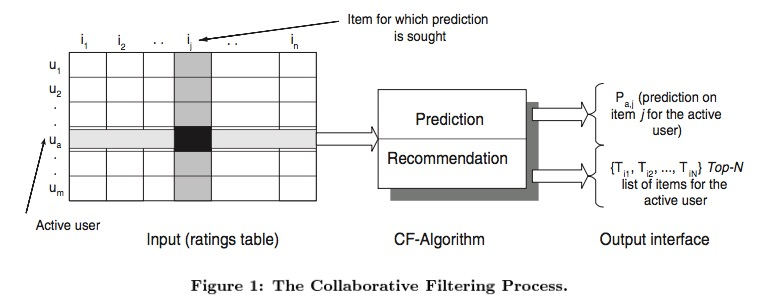

## Item based collaborative filtering

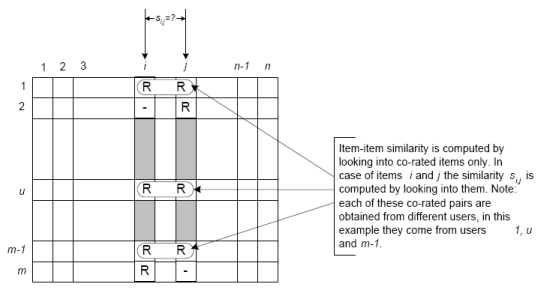

## Matrix factorization

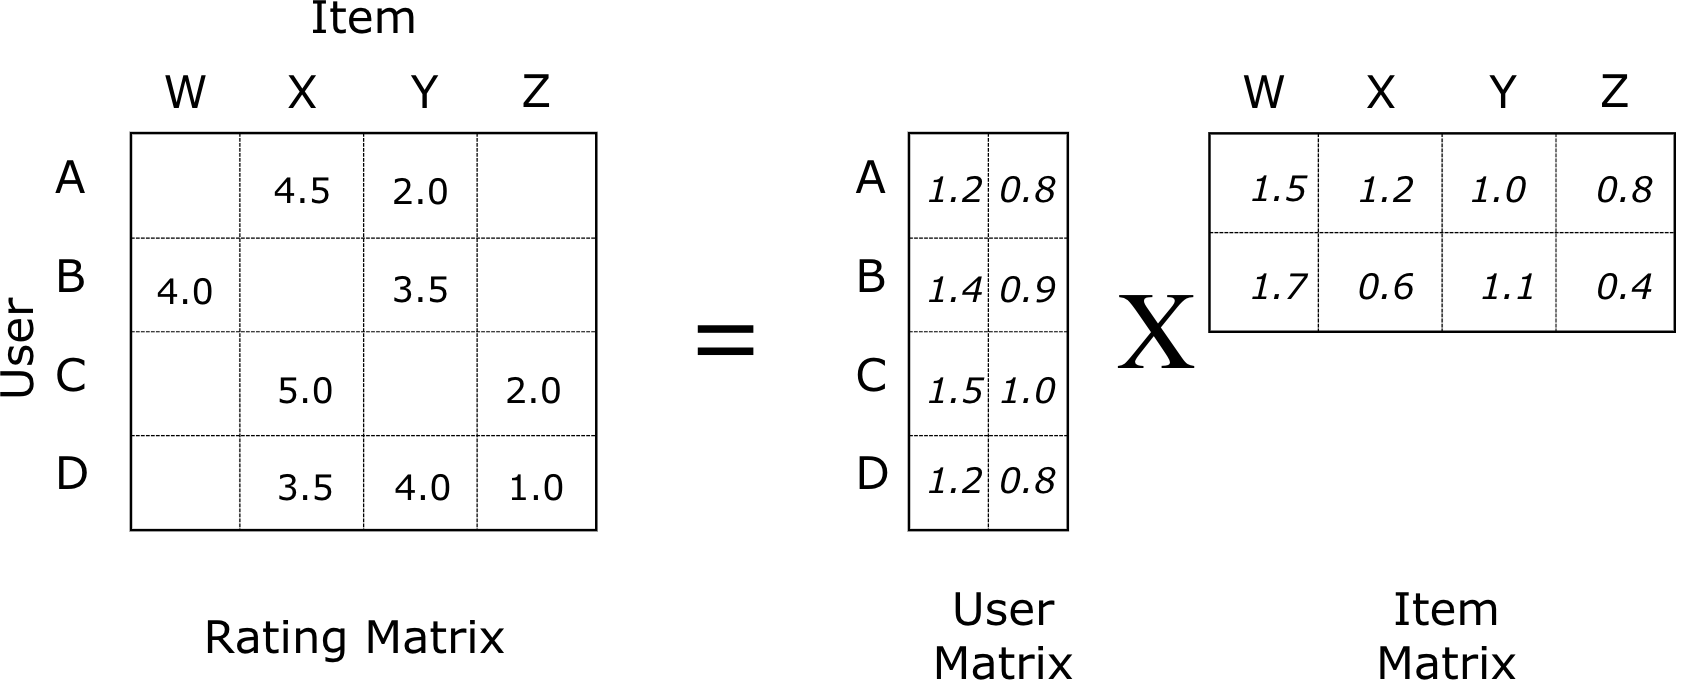

If by multiplication of '*User Matrix*' and '*Item Matrix*', one is able to get back existing values in '*Rating Matrix*' as close to as possible, there is little reason to doubt that blank values will also not be filled with correct values.
We can also interpret, that '*User Matrix*' displays two latent features and also how much importance a specific user gives to each latent feature. Similarly, '*Item Matrix*' also has a set of latent features (2 here) and also how much of that feature is present in an item.


It is possible to tune the expressive power of the model by changing the number of latent factors. It has been demonstrated that a matrix factorization with one latent factor is equivalent to a most popular or top popular recommender (e.g. recommends the items with the most interactions without any personalization). Increasing the number of latent factors will improve personalization, therefore recommendation quality, until the number of factors becomes too high, at which point the model starts to overfit and the recommendation quality will decrease.

## Recommendation using implicit data

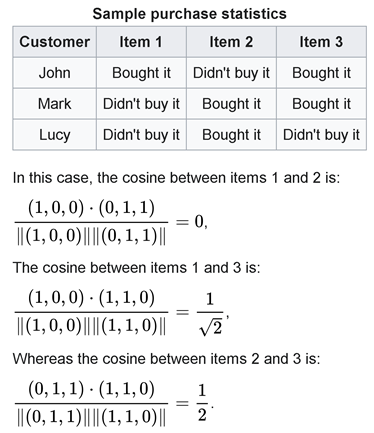

## Slope 1 Recommender Engine

Hence, a user visiting item 1 would receive item 3 as a recommendation, a user visiting item 2 would receive item 3 as a recommendation, and finally, a user visiting item 3 would receive item 1 (and then item 2) as a recommendation. The model uses a single parameter per pair of item (the cosine) to make the recommendation. 

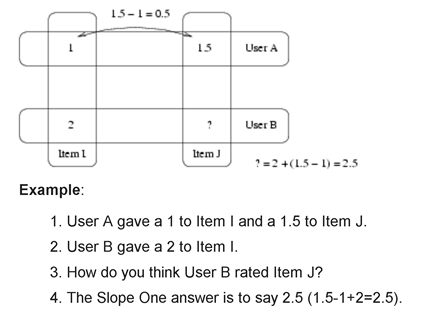

For a more realistic example, consider the following table. 

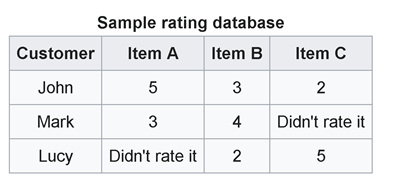

In this case, the average difference in ratings between item B and A is (2+(-1))/2=0.5. Hence, on average, item A is rated above item B by 0.5. Similarly, the average difference between item C and A is 3. Hence, if we attempt to predict the rating of Lucy for item A using her rating for item B, we get 2+0.5 = 2.5. Similarly, if we try to predict her rating for item A using her rating of item C, we get 5+3=8.

If a user rated several items, the predictions are simply combined using a weighted average where a good choice for the weight is the number of users having rated both items. In the above example, both John and Mark rated items A and B, hence weight of 2 and only John rated both items A and C, hence weight of 1 as shown below. we would predict the following rating for Lucy on item A as :

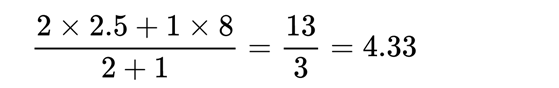

Hence, given n items, to implement Slope One, all that is needed is to compute and store the average differences and the number of common ratings for each of the n2 pairs of items. 

## Redcing candidates size

As number of items may be very very large, it is futile to look for similar items among all possible items. Better reduce candidate size. 

### Content based filtering

Here is user-item matrix.

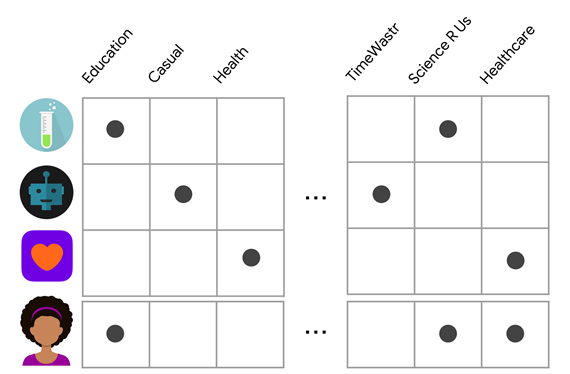

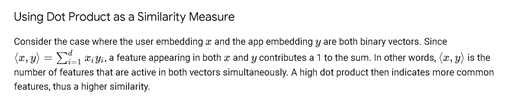

### Import libraries

In [ ]:
#https://grouplens.org/datasets/movielens/

In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

### Initiate spark session

In [ ]:
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

# 1. Load data

In [ ]:
movies = spark.read.csv("hdfs://localhost:9000/user/ashok/recommender/movies.csv",header=True)
ratings = spark.read.csv("hdfs://localhost:9000/user/ashok/recommender/ratings.csv",header=True)

In [ ]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
ratings = ratings.\
                   withColumn('userId', col('userId').cast('integer')).\
                   withColumn('movieId', col('movieId').cast('integer')).\
                   withColumn('rating', col('rating').cast('float')).\
                   drop('timestamp')
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



## Calculate sparsity

In [ ]:
# Count the total number of ratings in the dataset
numerator = ratings.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = np.round((1.0 - (numerator *1.0)/denominator)*100, 2)
f"The ratings dataframe is {sparsity}% empty"
#print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

'The ratings dataframe is 98.3% empty'

## Interpret ratings

In [ ]:
# Group data by userId, count ratings
userId_ratings = ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [ ]:
# Group data by movieId, count ratings
movieId_ratings = ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|     50|  204|
|   2858|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



## Build Out An ALS Model

In [ ]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Create test and train set
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)

train.count()
test.count()

19989

In [ ]:
# Create ALS model
als = ALS(
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            nonnegative = True,
            implicitPrefs = False,
            coldStartStrategy="drop"
          )

# Confirm that a model called "als" was created
type(als)

## Tell Spark how to tune your ALS model

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100]) \
            .addGrid(als.regParam, [.01, .1, .15]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  9


In [ ]:
# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [ ]:
          
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(
                                 metricName="rmse",
                                 labelCol="rating",
                                 predictionCol="prediction"
                                ) 


## Build your cross validation pipeline

In [ ]:
# Build cross validation using CrossValidator
cv = CrossValidator(
                     estimator=als,
                     estimatorParamMaps=param_grid,
                     evaluator=evaluator,
                     numFolds=3
                    )

# Confirm cv was built
print(cv)

CrossValidator_9f3e36749819


## Best Model and Best Model Parameters

In [ ]:
%%time

#Fit cross validator to the 'train' dataset
model = cv.fit(train)



CPU times: user 788 ms, sys: 458 ms, total: 1.25 s
Wall time: 3min 48s


In [ ]:
#Extract best model from the cv model above
best_model = model.bestModel

In [ ]:

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# # Print "Rank"
print("  Rank:", best_model._java_obj.parent().getRank())

# Print "MaxIter"
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
  Rank: 50
  MaxIter: 10
  RegParam: 0.15


In [ ]:
# View the predictions
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8682188942822926


In [ ]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   597|    471|   2.0| 4.1357207|
|   436|    471|   3.0| 3.6097066|
|   218|    471|   4.0| 2.9232428|
|   387|    471|   3.0| 3.0708382|
|   217|    471|   2.0| 2.7097173|
|   287|    471|   4.5| 2.9761252|
|    32|    471|   3.0| 3.7025106|
|   260|    471|   4.5| 3.5645263|
|   104|    471|   4.5| 3.5195568|
|   111|   1088|   3.0|  3.305781|
|   177|   1088|   3.5| 3.5467803|
|    41|   1088|   1.5|  2.449918|
|   387|   1088|   1.5| 2.6048868|
|   594|   1088|   4.5|  4.339765|
|   307|   1088|   3.0| 2.6175585|
|   509|   1088|   3.0| 3.1423986|
|   104|   1088|   3.0| 3.6711533|
|   268|   1238|   5.0| 3.7693748|
|   462|   1238|   3.5|  3.369685|
|   307|   1342|   2.0|  2.299802|
+------+-------+------+----------+
only showing top 20 rows



## Make Recommendations

In [ ]:
# Generate n Recommendations for all users
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[3379, 4.834906]...|
|   463|[[3379, 5.058715]...|
|   496|[[3379, 4.5754867...|
|   148|[[33649, 4.460032...|
|   540|[[3379, 5.3912764...|
|   392|[[3379, 4.696207]...|
|   243|[[67618, 5.629416...|
|    31|[[3379, 4.981336]...|
|   516|[[4429, 4.8097], ...|
|   580|[[3379, 4.8408875...|
+------+--------------------+



In [ ]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   471|   3379| 4.834906|
|   471|   8477| 4.575323|
|   471|   7096|4.5383263|
|   471|  33649|4.5357804|
|   471|  86781|4.5016623|
|   471|   7767|4.4983916|
|   471| 171495| 4.490844|
|   471| 100714| 4.419473|
|   471|  78836|4.4031296|
|   471|  32582|4.3969116|
+------+-------+---------+



## Do the recommendations make sense?
Lets merge movie name and genres to teh recommendation matrix for interpretability.

In [ ]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|  67618|   100|5.1405735|Strictly Sexual (...|Comedy|Drama|Romance|
|   3379|   100| 5.006642| On the Beach (1959)|               Drama|
|  33649|   100|5.0065255|  Saving Face (2004)|Comedy|Drama|Romance|
|  42730|   100|4.9775596|   Glory Road (2006)|               Drama|
|  74282|   100| 4.915519|Anne of Green Gab...|Children|Drama|Ro...|
|  26073|   100| 4.874221|Human Condition I...|           Drama|War|
| 184245|   100| 4.874221|De platte jungle ...|         Documentary|
|  84273|   100| 4.874221|Zeitgeist: Moving...|         Documentary|
|   7071|   100| 4.874221|Woman Under the I...|               Drama|
| 117531|   100| 4.874221|    Watermark (2014)|         Documentary|
+-------+------+---------+--------------------+--------------------+



In [ ]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(10).show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|   1101|   100|   5.0|      Top Gun (1986)|      Action|Romance|
|   1958|   100|   5.0|Terms of Endearme...|        Comedy|Drama|
|   2423|   100|   5.0|Christmas Vacatio...|              Comedy|
|   4041|   100|   5.0|Officer and a Gen...|       Drama|Romance|
|   5620|   100|   5.0|Sweet Home Alabam...|      Comedy|Romance|
|    368|   100|   4.5|     Maverick (1994)|Adventure|Comedy|...|
|    934|   100|   4.5|Father of the Bri...|              Comedy|
|    539|   100|   4.5|Sleepless in Seat...|Comedy|Drama|Romance|
|     16|   100|   4.5|       Casino (1995)|         Crime|Drama|
|    553|   100|   4.5|    Tombstone (1993)|Action|Drama|Western|
+-------+------+------+--------------------+--------------------+

